In [ ]:
from google.colab import drive
drive.mount('./content')

Mounted at ./content


In [ ]:
from numpy import random
import numpy as np
import pandas as pd
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

import numpy as np
from keras.layers import Input
import keras
from keras import Input, Model
from keras.layers import Dense, LeakyReLU, concatenate
from keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam


import tensorflow



tensorflow.random.set_seed(exp_config.model.random_seed)

In [ ]:
import os

random_seed = 1985


exp_config = Config(
        model=ModelConfig(activation="relu", lr_gen=0.001, lr_disc=0.001, dec_gen=0, 
                                 optim_gen="Adam", optim_disc="Adam", z_input_size=10, random_seed=random_seed),
        training=TrainingConfig(n_epochs=100, batch_size=8, n_samples=50),
        
        run=RunConfig(save_fig=1)
    )



In [ ]:
from __future__ import print_function, division

def build_generator(network):
    seed = network.seed
    random_normal = keras.initializers.RandomNormal(seed=seed)

    if network.activation == "linear":
        activation = "linear"
        kerner_initializer = keras.initializers.RandomUniform(seed=seed)
    elif network.activation == "elu":
        activation = "elu"
        kerner_initializer = keras.initializers.he_normal(seed=seed)
    elif network.activation == "selu":
        activation = "selu"
        kerner_initializer = keras.initializers.he_normal(seed=seed)
    elif network.activation == "relu":
        activation = "relu"
        kerner_initializer = keras.initializers.he_uniform(seed=seed)
    elif network.activation == "lrelu":
        activation = LeakyReLU()
        kerner_initializer = keras.initializers.he_normal(seed=seed)
    elif network.activation == "tanh":
        activation = "tanh"
        kerner_initializer = keras.initializers.RandomUniform(seed=seed)
    elif network.activation == "sigmoid":
        activation = "sigmoid"
        kerner_initializer = keras.initializers.RandomUniform(seed=seed)
    else:
        raise NotImplementedError("Activation not recognized")

   

    if network.architecture == 3:
        x = Input(shape=(network.x_input_size,), dtype='float')
        x_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(x)

        noise = Input(shape=(network.z_input_size,))
        noise_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(noise)

        concat = concatenate([x_output, noise_output])

        output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
        output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
        output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
        output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
        output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
        output = Dense(network.y_input_size, activation="linear", kernel_initializer=random_normal)(output)

        model = Model(inputs=[noise, x], outputs=output)


    else:
        raise NotImplementedError("Architecture does not exist")

    return model


def build_discriminator(network):
    seed = network.seed
    random_uniform = keras.initializers.RandomUniform(seed=seed)

    if network.activation == "linear":
        activation = "linear"
        kerner_initializer = keras.initializers.RandomUniform(seed=seed)
    elif network.activation == "elu":
        activation = "elu"
        kerner_initializer = keras.initializers.he_normal(seed=seed)
    elif network.activation == "selu":
        activation = "selu"
        kerner_initializer = keras.initializers.he_normal(seed=seed)
    elif network.activation == "relu":
        activation = "relu"
        kerner_initializer = keras.initializers.he_uniform(seed=seed)
    elif network.activation == "lrelu":
        activation = LeakyReLU()
        kerner_initializer = keras.initializers.he_normal(seed=seed)
    elif network.activation == "tanh":
        activation = "tanh"
        kerner_initializer = keras.initializers.RandomUniform(seed=seed)
    elif network.activation == "sigmoid":
        activation = "sigmoid"
        kerner_initializer = keras.initializers.RandomUniform(seed=seed)
    else:
        raise NotImplementedError("Activation not recognized")


    if network.architecture == 3:
        x = Input(shape=(network.x_input_size,), dtype='float')
        x_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(x)

        label = Input(shape=(network.y_input_size,))
        label_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(label)

        concat = concatenate([x_output, label_output])
        concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
        concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
        concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
        concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
        validity = Dense(1, activation="sigmoid", kernel_initializer=random_uniform)(concat)

        model = Model(inputs=[x, label], outputs=validity)

    

    else:
        raise NotImplementedError("Architecture does not exist")

    return model


class CGAN():
    def __init__(self, exp_config):
        if exp_config.model.optim_gen == "Adam":
            self.optimizer_gen = Adam(exp_config.model.lr_gen, decay=exp_config.model.dec_gen)
        else:
            self.optimizer_gen = SGD(exp_config.model.lr_gen, decay=exp_config.model.dec_gen)
        if exp_config.model.optim_disc == "Adam":
            self.optimizer_disc = Adam(exp_config.model.lr_disc, decay=exp_config.model.dec_disc)
        else:
            self.optimizer_disc = SGD(exp_config.model.lr_disc, decay=exp_config.model.dec_disc)
        self.activation = exp_config.model.activation
        self.seed = exp_config.model.random_seed
        #self.scenario = exp_config.dataset.scenario
        self.x_input_size = 203
        self.y_input_size = 1
        self.z_input_size = exp_config.model.z_input_size
        self.architecture = 3
      
       
  

        if exp_config.model.architecture is not None:
            self.architecture = exp_config.model.architecture

        # Build and compile the discriminator
        self.discriminator = build_discriminator(self)
        self.discriminator.compile(
            loss=['binary_crossentropy'],
            optimizer=self.optimizer_disc,
            metrics=['accuracy'])

        # Build the generator
        self.generator = build_generator(self)

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.z_input_size,))

        x = Input(shape=(self.x_input_size,))
        label = self.generator([noise, x])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        validity = self.discriminator([x, label])

        # The combined model (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, x], validity)
        self.combined.compile(
            loss=['binary_crossentropy'],
            optimizer=self.optimizer_gen)

    def train(self, xtrain, ytrain, epochs, batch_size=128, verbose=True):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        dLossErr = np.zeros([epochs, 1])
        dLossReal = np.zeros([epochs, 1])
        dLossFake = np.zeros([epochs, 1])
        gLossErr = np.zeros([epochs, 1])
        genPred = np.zeros([epochs, 1])
        genReal = np.zeros([epochs, 1])

        for epoch in range(epochs):
            for batch_idx in range(int(xtrain.shape[0] // batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Select a random half batch of images
                idx = np.random.randint(0, xtrain.shape[0], batch_size)
                x, true_labels = xtrain[idx], ytrain[idx]
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.z_input_size))
                # Generate a half batch of new images
                fake_labels = self.generator.predict([noise, x])
                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch([x, true_labels], valid)
                d_loss_fake = self.discriminator.train_on_batch([x, fake_labels], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------
                # Condition on x
                idx = np.random.randint(0, xtrain.shape[0], batch_size)
                sample = xtrain[idx]
                # Train the generator
                g_loss = self.combined.train_on_batch([noise, sample], valid)

            dLossErr[epoch] = d_loss[0]
            dLossReal[epoch] = d_loss_real[0]
            dLossFake[epoch] = d_loss_fake[0]
            gLossErr[epoch] = g_loss

            if verbose:
                print(f"Epoch: {epoch} / dLoss: {d_loss[0]} / gLoss: {g_loss}")

            ypred = self.predict(xtrain)
            genPred[epoch] = np.average(ypred)
            genReal[epoch] = np.average(ytrain)

        return dLossErr, dLossReal, dLossFake, gLossErr, genPred, genReal

    def predict(self, xtest):
        noise = np.random.normal(0, 1, (xtest.shape[0], self.z_input_size))
        ypred = self.generator.predict([noise, xtest])
       # rmse = np.mean((ypred-y_test))
        return ypred

    def sample(self, xtest, n_samples):
        y_samples_gan = self.predict(xtest)
        for i in range(n_samples - 1):
            ypred_gan = self.predict(xtest)
            y_samples_gan = np.hstack([y_samples_gan, ypred_gan])
        median = []
        mean = []
        for j in range(y_samples_gan.shape[0]):
            median.append(np.median(y_samples_gan[j, :]))
            mean.append(np.mean(y_samples_gan[j, :]))

        return np.array(mean).reshape(-1, 1), np.array(median).reshape(-1, 1), y_samples_gan

import typing


class RunConfig(typing.NamedTuple):
    save_fig: int = 0
    save_pdf: int = 0


class ModelConfig(typing.NamedTuple):
    architecture: int = None
    lr_gen: float = 0.001
    lr_disc: float = 0.001
    optim_gen: str = "Adam"
    optim_disc: str = "SGD"
    dec_gen: float = 0
    dec_disc: float = 0
    random_seed: int = 1985
    activation: str = "elu"
    z_input_size: int = 1


class TrainingConfig(typing.NamedTuple):
    n_epochs: int = 100
    batch_size: int = 16
    n_samples: int = 100


class Config(typing.NamedTuple):
    run: RunConfig
    model: ModelConfig
    training: TrainingConfig

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#train = pd.read_csv('/content/content/MyDrive/0302/train.csv')
valid = pd.read_csv('/content/content/MyDrive/0302/val.csv')
test = pd.read_csv('/content/content/MyDrive/0302/test.csv')

train = pd.read_csv('/content/content/MyDrive/0302/cgan.csv')

x_train = train.drop(['6.56'],axis = 1).values
y_train = train['6.56'].values


x_valid = valid.drop(['6.61'],axis = 1).values
y_valid = valid['6.61'].values

x_test = test.drop(['5.85'], axis =1).values
y_test = test['5.85'].values


In [ ]:
test.iloc[:,-1]

0      4.41
1      4.15
2      5.76
3      5.31
4      4.38
       ... 
181    8.64
182    4.55
183    4.50
184    5.66
185    6.04
Name: 5.85, Length: 186, dtype: float64

In [ ]:
cgan = CGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(x_train, y_train, 
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size)

1/1 [==============================] - 0s 26ms/step
Epoch: 0 / dLoss: 1.6653969287872314 / gLoss: 0.31623464822769165
1/1 [==============================] - 0s 47ms/step
Epoch: 1 / dLoss: 0.4845535159111023 / gLoss: 0.8301180601119995
1/1 [==============================] - 0s 28ms/step
Epoch: 2 / dLoss: 0.5865227729082108 / gLoss: 1.9265073537826538
1/1 [==============================] - 0s 25ms/step
Epoch: 3 / dLoss: 0.550255537033081 / gLoss: 0.7347865104675293
1/1 [==============================] - 0s 26ms/step
Epoch: 4 / dLoss: 0.48957502841949463 / gLoss: 2.8752949237823486
1/1 [==============================] - 0s 27ms/step
Epoch: 5 / dLoss: 0.858332633972168 / gLoss: 0.39708247780799866
1/1 [==============================] - 0s 21ms/step
Epoch: 6 / dLoss: 0.7201845347881317 / gLoss: 1.1961381435394287
1/1 [==============================] - 0s 25ms/step
Epoch: 7 / dLoss: 0.4632735997438431 / gLoss: 1.47688889503479
1/1 [==============================] - 0s 25ms/step
Epoch: 8 / dL

KeyboardInterrupt: ignored

In [ ]:
ypred_mean_gan_valid, ypred_median_gan_valid, ypred_gan_sample_valid = cgan.sample(x_valid, 
                                                                                exp_config.training.n_samples)


In [ ]:
ypred_mean_gan_valid.shape

(185, 1)

In [ ]:
ypred_mean_gan_test, ypred_median_gan_test, ypred_gan_sample_test = cgan.sample(x_test, 
                                                                                exp_config.training.n_samples)
ypred_median_gan_test

6/6 [==============================] - 0s 3ms/step


array([[4.662397 ],
       [4.344189 ],
       [5.447385 ],
       [5.2058306],
       [4.7643003],
       [5.783629 ],
       [6.7795043],
       [4.861017 ],
       [6.97248  ],
       [4.863016 ],
       [5.2727838],
       [5.641837 ],
       [6.5938444],
       [5.6956415],
       [5.173106 ],
       [5.744489 ],
       [4.401615 ],
       [5.3569403],
       [4.190065 ],
       [6.517747 ],
       [4.7130985],
       [5.9622154],
       [5.8943424],
       [4.406685 ],
       [6.6425657],
       [5.5532875],
       [5.8441434],
       [5.3124886],
       [6.414332 ],
       [7.2211256],
       [6.8714724],
       [6.7818546],
       [4.670374 ],
       [6.981739 ],
       [5.8596764],
       [5.542779 ],
       [4.3720846],
       [5.1596193],
       [5.9043665],
       [4.999344 ],
       [4.711941 ],
       [4.6607304],
       [6.180406 ],
       [5.8490357],
       [4.8789244],
       [4.9437666],
       [4.414424 ],
       [4.6688766],
       [4.812782 ],
       [5.6383743],


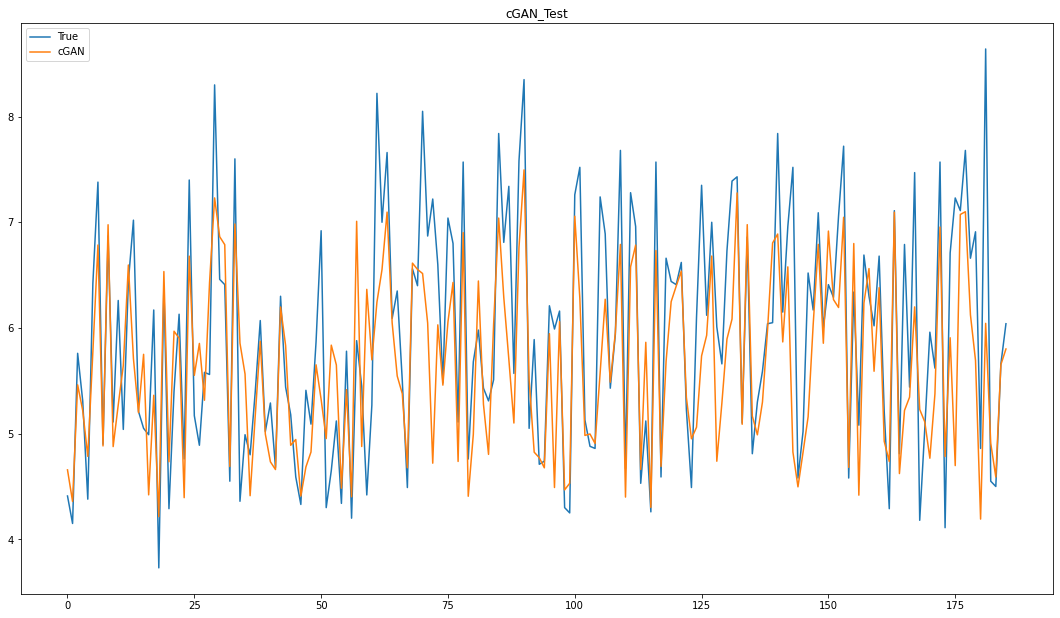

EVS: 0.5867158220379682
R2: 0.5258343172898019
mape: 0.09820128277885774
rmse: 0.7634286809797609


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import explained_variance_score,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time
from sklearn import metrics
import csv
import matplotlib.pyplot as plt  

plt.plot(y_test)
plt.plot(ypred_mean_gan_test)
plt.legend(['True','cGAN'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("cGAN_Test")  
plt.savefig("/content/content/MyDrive/cGAN_tes.png")

plt.show()
print("EVS:",explained_variance_score(y_test,ypred_mean_gan_test))
print("R2:",metrics.r2_score(y_test,ypred_mean_gan_test))
print("mape:",mean_absolute_percentage_error(ypred_mean_gan_test,y_test))
print("rmse:",np.sqrt(mean_squared_error(ypred_median_gan_test,y_test)))


In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1,eta=0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 2000)
xg_reg.fit(x_train,y_train)
from sklearn.metrics import mean_absolute_error

ypred_xg_test = xg_reg.predict(x_test)
xg_mae = mean_absolute_error(ypred_xg_test, y_test)
print(xg_mae)

cov_xg = np.mean((y_test - ypred_xg_test)**2)
print(np.sqrt(mean_squared_error(ypred_xg_test,y_test)))

0.5590120245820731
0.7341569301926743


In [ ]:
print("R2:",metrics.r2_score(y_test,ypred_xg_test))


R2: 0.5572748229191142


In [ ]:
pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 KB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp38-cp38-linux_x86_64.whl size=3424739 sha256=e9692ad814ff09c88956b5d5db0a9d3793c0f61c54f13d0f7f0320cdae5cf085
  Stored in directory: /root/.cache/pip/wheels/48/b3/22/31f07cfd7b182ea3703151b7e5a7d6447e3e1ac6aa5c529413
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=7cc0396f9299be2c5b83ba51935cf76845bb342b4087c41565832ab10146242d
  Stored in directory: /root/.cache/pip/wheels/66/78/6c/d98cb437834de5e29381786b4ba8a77ea68cca74653ab62713
Successfully built GPy paramz


In [ ]:
import GPy

run_hyperopt_search = True
rbf = True

if rbf:
    kernel = GPy.kern.RBF(input_dim=cgan.x_input_size, variance=0.1, lengthscale=1)
else:
    kernel = GPy.kern.sde_RatQuad(input_dim=X_train.shape[1], variance=variance, lengthscale=length, power=power)

gpr = GPy.models.GPRegression(x_train, y_train.reshape(-1, 1), kernel, noise_var=0.1)

if run_hyperopt_search:
    gpr.optimize(messages=True)

ll = gpr.log_likelihood()
ll

-646.6468640137643

In [ ]:
import GPy

# define the likelihood function
likelihood = GPy.likelihoods.Gaussian(variance=0.1)

run_hyperopt_search = True
rbf = True

if rbf:
    kernel = GPy.kern.RBF(input_dim=cgan.x_input_size, variance=0.1, lengthscale=1)
else:
    kernel = GPy.kern.sde_RatQuad(input_dim=X_train.shape[1], variance=variance, lengthscale=length, power=power)

gpr = GPy.models.GPRegression(x_train, y_train.reshape(-1, 1), kernel, noise_var=0.1)

if run_hyperopt_search:
    gpr.optimize(messages=True)

# calculate the log-likelihood between y_pred and y_test
log_likelihood = likelihood.logpdf(y_test.reshape(-1, 1), gpr.predict(x_test)[0])

ypred_gp_test, cov_test = gpr.predict(x_test)


In [ ]:
log_likelihood.std()

3.914167673346449

In [ ]:
ypred_gp_test, cov_test = gpr.predict(x_test)
print("R2:",metrics.r2_score(y_test,ypred_gp_test))
print(np.sqrt(mean_squared_error(ypred_gp_test,y_test)))

R2: 0.6498507253905232
0.6529026150371636


In [174]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the number of folds
n_folds = 5

# Split the data into folds
kf = KFold(n_splits=n_folds)
kf.get_n_splits(x_train)

# Initialize lists to store the results for each fold
rmse_scores = []
r2_scores = []
log_likelihoods = []

# Loop over the folds
for train_index, test_index in kf.split(x_train):
    # Split the data into training and test sets for this fold
    x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Fit the GP model on the training set for this fold
    gpr_fold = GPy.models.GPRegression(x_train_fold, y_train_fold.reshape(-1, 1), kernel, noise_var=0.1)
    gpr_fold.optimize(messages=True)

    # Calculate the log-likelihood, RMSE, and R^2 on the test set for this fold
    ypred_gp_test_fold, cov_test_fold = gpr_fold.predict(x_test_fold)
    log_likelihood_fold = np.sum(-0.5 * np.log(2 * np.pi * cov_test_fold) - 0.5 * np.square(y_test_fold - ypred_gp_test_fold) / cov_test_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, ypred_gp_test_fold))
    r2_fold = r2_score(y_test_fold, ypred_gp_test_fold)

    # Append the results for this fold to the lists
    log_likelihoods.append(log_likelihood_fold)
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Calculate the mean log-likelihood, RMSE, and R^2 across all folds
mean_log_likelihood = np.mean(log_likelihoods)
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

print("Mean log-likelihood: ", mean_log_likelihood)
print("Mean RMSE: ", mean_rmse)
print("Mean R^2: ", mean_r2)


Mean log-likelihood:  -33380.64805662329
Mean RMSE:  0.7627430293609678
Mean R^2:  0.5032843666176765


In [172]:
kf.split(np.vstack((x_train, x_test))).shape

AttributeError: ignored